# Greyscale calibration 

This script is able to extract the data from the 16x8 matrix of greyscale values to for calibration of GS contrast curves using the Polytec MSA-500 topography measurement.

1. A `gs_calirbationv20240125.dxf` calibration mask was produced using the `klayout.ipynb` script.
2. This mask is exposed for different `Energy` and `Focus` conditions on the wafer
3. The PR is then developed and the wafer is characterized under the Polytec MSA-500 topography measurements. Check the conditions below to achieve a proper measuremnet of the polytec.
4. Then use the extracted `TMS_E90_F40_matrix.txt` file to process using this script


## Polytec measurement conditions


1. Place the sample under the 10x topography microscope objective as flat as possible
2. Adjust the focus so the fringes are starting on the surface of the measurement plane (top of photoresist)
3. Adjust the start and stop measurement range of the polytec in the software

### Under the Polytec preconditons:
- Filter settings:
    - S-filter: check
        - cut off wavelength x and y both at 10µm
    - Erosion: check
        - width: 11
        - height: 11
        - rectangular: check
        - clip: check
    - Median filter:
        - width: 21
        - height: 21
        - fill: check
        - rectangular: check
- TMS measurement settings:
    - Threshold: 10
    - number of correlograms: 1
    - vibration compensation: check



## Script:

1. Load the `file = "TMS_E90_F40_matrix.txt"`
2. Adjust the `region_origin = ( x0, y0)` values to match the square of the greylevel 0
3. Adjust the `region_tilt_angle = 0` in degrees in case the data is tilted so that the dots are placed near the center of each square
4. Confirm the location of the measurement positions, and set the `export_data = True` flag so that the image files and `.csv` output calibration files are exported.






In [50]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd


from scipy import interpolate
import os

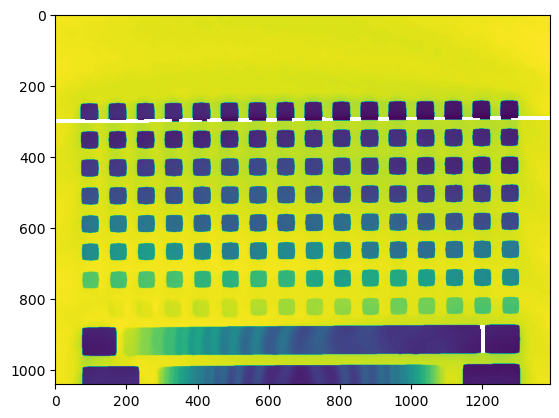

In [205]:

path = ""

file = "TMS_E100_F40_matrix.txt"
file = "TMS_E100_F-40_matrix.txt"
file = "TMS_E100_F0_matrix.txt"
file = "TMS_E90_F40_matrix.txt"

filename = os.path.join(path, file)

# Read matrix data
data = np.genfromtxt(filename,delimiter='\t')

# Convert to µm topography
data *= 1000
plt.imshow(data)




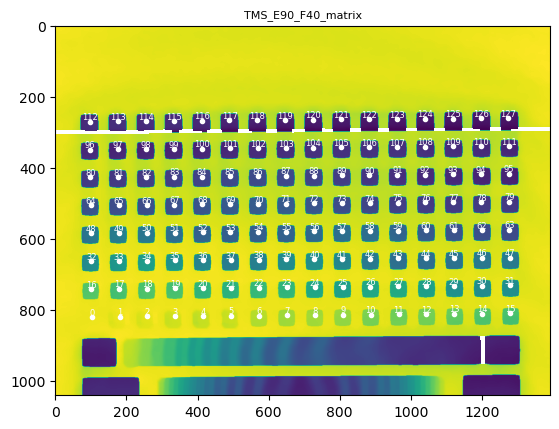

In [213]:
# Create the regions vector

# Adjust the region_origin position and tilt angle on the image, 
# then set the export_data flag to True


region_origin = (95, 820)


export_data = True
# export_data = False

region_tilt_angle = -0.5

region_width = 20
region_height = region_width
region_cols = 16
region_rows = 8
region_step_x = 78.5
region_step_y = region_step_x

regions = []

region_x = []
region_y = []

indexes = range(region_cols*region_rows)

plt.imshow(data)
for ri in range(region_rows):
    for ci in range(region_cols):
        # index = ci*region_rows+ri
        index = ri*region_cols+ci

        
        # print(index, ci, ri)
        # regions[index] =(np.where(xx)) 
        x = region_origin[0]+ci*region_step_x
        y = region_origin[1]-ri*region_step_y

        x1 = x*np.cos(np.radians(region_tilt_angle)) - y*np.sin(np.radians(region_tilt_angle))
        y1 = x*np.sin(np.radians(region_tilt_angle)) + y*np.cos(np.radians(region_tilt_angle))

        x,y = x1,y1
        plt.plot(x,y, 'w.')
        plt.text(x,y, index, fontsize=6, va='bottom', ha='center', c='w')

        region_x.append(x)
        region_y.append(y)

# print(region_x, region_y)


file_text = os.path.splitext(file)[0]


plt.title(file_text, fontsize=8)


if export_data:
    test_filename = file_text+"_measurement.png"
    plt.savefig(os.path.join(path, test_filename))



C:\Users\daguiam264\AppData\Local\Temp\ipykernel_23700\1881738874.py:35: RuntimeWarning: overflow encountered in exp
  m = np.exp(-C*x)
C:\Users\daguiam264\AppData\Local\Temp\ipykernel_23700\1881738874.py:37: RuntimeWarning: overflow encountered in power
  return np.exp(e1+e2*m+e3*np.power(m,2)) + e4*x
C:\Users\daguiam264\AppData\Local\Temp\ipykernel_23700\1881738874.py:37: RuntimeWarning: invalid value encountered in add
  return np.exp(e1+e2*m+e3*np.power(m,2)) + e4*x
C:\Users\daguiam264\AppData\Local\Temp\ipykernel_23700\1881738874.py:37: RuntimeWarning: overflow encountered in exp
  return np.exp(e1+e2*m+e3*np.power(m,2)) + e4*x


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

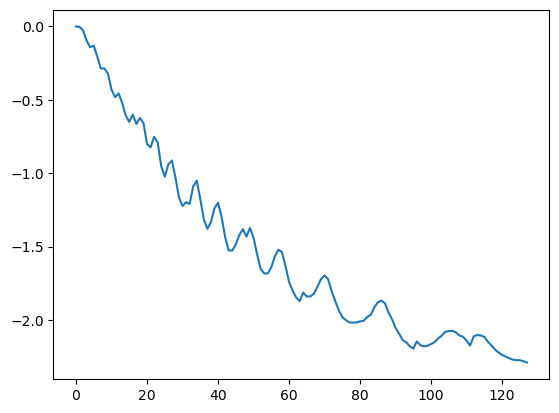

In [216]:


depths = []
depths_std = []
for index, (x,y) in enumerate(zip(region_x, region_y)):
    # print(index, x,y)

    
    region_data = data[int(y-region_height/2):int(y+region_height/2),
                       int(x-region_width/2):int(x+region_width/2)]
    
    region_mean = np.nanmean(region_data)
    region_std = np.nanstd(region_data)
    # print(int(x-region_width/2),int(x+region_width/2))
    # print(int(y-region_height/2),int(y+region_height/2))
    # print(data[int(x-region_width/2):int(x+region_width/2)][int(y-region_height/2):int(y+region_height/2)])
    # print(index,x,y,value, data.shape, region_data.shape)
    depths.append(region_mean)
    depths_std.append(region_std)



depths = np.array(depths)
depths_std = np.array(depths_std)

# normalize so the first value is 0
depths -= depths[0]



plt.figure()
plt.plot(indexes, depths)


# depths = depths-depths[-1]
def gs_fit_curve(x, e1, e2 ,e3, e4, C,):
    m = np.exp(-C*x)

    return np.exp(e1+e2*m+e3*np.power(m,2)) + e4*x 


from scipy.optimize import curve_fit


depths -= depths[-1]

popt, pcov = curve_fit(gs_fit_curve, indexes, depths)

fit_depth = gs_fit_curve(indexes, *popt)
depths -= depths[0]
fit_depth -= fit_depth[0]
# print(popt)
# plt.plot(indexes, depths)
plt.plot(indexes, fit_depth)
fit_depth[-1]


# plt.plot(indexes,depths_std)
plt.errorbar(indexes,depths, yerr=depths_std*2)

plt.xlabel("Grey level")
plt.ylabel("Depth [µm]")


plt.title(file_text, fontsize=8)


if export_data:

    test_filename = file_text+"_raw_data.png"
    plt.savefig(os.path.join(path, test_filename))

    raw_filename = file_text+"_raw_data.csv"

    np.savetxt(os.path.join(path, raw_filename), 
            np.array([indexes, depths, depths_std, fit_depth]).T, 
            delimiter=',',
            fmt=['%d', '%0.3f', '%0.3f', '%0.3f'],
            header='greylevel, depth, depth_std, fit_depth')


    raw_filename = file_text+"_gs_calibration.csv"

    np.savetxt(os.path.join(path, raw_filename), 
            np.array([indexes, fit_depth]).T, 
            delimiter=',',
            fmt=['%d', '%0.3f'],
            header='greylevel, depth')


